<a href="https://colab.research.google.com/github/l-arkadiy-l/desease/blob/main/GOTO_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arkadiykleymenov","key":"d14784414ee7bcd4fdaafa6cfd337d81"}'}

In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets list

ref                                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset                  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36            853        639  0.9375           
datasets/muratkokludataset/rice-image-dataset                                  Rice Image Dataset                               219MB  2022-04-03 02:12:00            869        591  0.875            
datasets/mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education    6KB  2022-04-16 04:46:28           3353         82  1.0              


In [5]:
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('kmader/skin-cancer-mnist-ham10000', 'HAM10000_images_part_2')

In [7]:
import zipfile
path_to_zip_file = '/content/HAM10000_images_part_1/skin-cancer-mnist-ham10000.zip'
with zipfile.ZipFile('/content/HAM10000_images_part_2/skin-cancer-mnist-ham10000.zip', 'r') as z:
    z.extractall('/content/HAM10000_images_part_1')

In [3]:
# ----- start coding
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
from torch import optim

In [4]:
name_folder = '/content/HAM10000_images_part_1'
data = pd.read_csv(f'{name_folder}/HAM10000_metadata.csv')
data = data.head(data.size)
dict_sex = {
    'male': 0, 
    'female': 1
}
dict_disease = {
    'mel': 0, 
    'bkl': 1, 
    'df': 2, 
    'nv': 3, 
    'bcc': 4, 
    'vasc': 5, 
    'akiec': 6
    }
dict_type = {
    'follow_up': 0,
    'consensus': 1, 
    'confocal': 2, 
    'histo': 3
}

dict_localization = {
    'back': 0, 
    'ear': 1, 
    'scalp': 2, 
    'lower extremity': 3, 
    'hand': 4, 
    'foot': 5, 
    'acral': 6, 
    'chest': 7, 
    'trunk': 8,
    'genital': 9, 
    'neck': 10,
    'abdomen': 11,
    'upper extremity': 12, 
    'face': 14
}

for j in data.iterrows():
    # print(j[1]['sex'], j[1]['image_id'], data[data['image_id'] == j[1]['image_id']])
    # img = Image.open(f"/HAM10000_images/{j[1][1]}.jpg")
    try:
        data.at[j[0], 'sex'] = dict_sex[j[1]['sex']]
        data.at[j[0], 'dx'] = dict_disease[j[1]['dx']]
        data.at[j[0], 'dx_type'] = dict_type[j[1]['dx_type']]
        data.at[j[0], 'localization'] = dict_localization[j[1]['localization']]
        # print(data[data['image_id'] == j[1]['image_id']])
    except KeyError:
        # print('unknow')
        data[data['image_id'] == j[1]['image_id']] = ''
        pass
data.to_csv(f'{name_folder}/test.csv', index=False)


In [10]:
img_width, img_height = (600, 450)

In [5]:
data = pd.read_csv(f'{name_folder}/hmnist_28_28_RGB.csv')
x = torch.from_numpy(data.values)[:, :-1]
y = torch.from_numpy(data.values)[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y)
dataset = torch.utils.data.TensorDataset(x_train, y_train)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

testset = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)
# print(torch.utils.data.TensorDataset())
print(x_train, y_train)


tensor([[228, 158, 161,  ..., 211, 147, 153],
        [227, 146, 141,  ..., 216, 148, 133],
        [176, 125, 133,  ..., 150, 101, 108],
        ...,
        [174, 164, 189,  ..., 156, 130, 150],
        [111,  90, 100,  ..., 115,  93, 106],
        [  0,   0,   0,  ...,   0,   0,   0]]) tensor([4, 4, 0,  ..., 2, 4, 6])


In [6]:

model = nn.Sequential(
    nn.Conv2d(3, 64, 3, 1),
    nn.GELU(),
    nn.Conv2d(64, 128, 3, 1), 
    nn.GELU(),
    nn.Conv2d(128, 256, 3, 1),
    nn.GELU(),
    nn.Flatten(),
    nn.Linear(123904, 7),
    nn.LogSoftmax(dim=1)
)
model = model.cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 11
for i in range(epochs):
  running_loss = 0
  for images, labels in data_loader:
    
    images = images.reshape(-1, 3, 28, 28).type(torch.cuda.FloatTensor).cuda()
    labels = labels.cuda()
    loss = criterion(model(images), labels)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    running_loss += loss.item()
  print(f'Training Loss: {running_loss / len(data_loader)}')


Training Loss: 33.8429978116084
Training Loss: 1.8937647019402455
Training Loss: 1.8431611727860013
Training Loss: 1.8118524935285925
Training Loss: 1.7448823977324923
Training Loss: 1.698273054624008
Training Loss: 1.65338717072697
Training Loss: 1.611165483119124
Training Loss: 1.5707302012686002
Training Loss: 1.533292956271414
Training Loss: 1.4974465653047724


In [13]:
87*3*28**2

204624

In [7]:
for images, labels in data_loader:
  a = images.cpu().numpy()
  a = a.view().reshape(-1,  28, 28, 3)
#   print(a)
#   # break
# print(a)

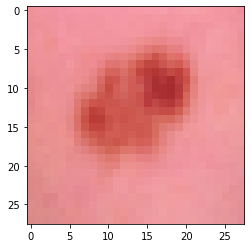

In [8]:
from matplotlib import pyplot as plt
plt.imshow(a[3])

In [65]:
dict_labels = {0: '(akiec)', 1: '(bcc)', 2: '(bkl)', 3: 'dermatofibroma (df)', 4:'melanoma (mel)', 5: 'melanocytic nevi (nv)', 6: 'vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)', 7: ''}


In [10]:
import torch
def calc_accuracy(output, labels):
  dict_cnt = {i : 0 for i in range(7)}
  ans_labels = torch.argmax(output, dim=1) # ans_labesl = pred_labels = y с крышкой
  coincidence = labels.cuda() == ans_labels.cuda()
  coincidence = coincidence.type(torch.cuda.FloatTensor) # from bool to float
  tm = torch.mean(coincidence)
  return [tm, ans_labels]

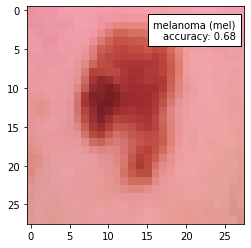

In [77]:
from matplotlib import pyplot as plt
from time import sleep
dataiter = iter(data_loader)
# print(images.shape)
output = model(images.reshape(-1, 3, 28, 28).type(torch.cuda.FloatTensor).cuda())
for i in range(2):
  images, labels = dataiter.next() # бач картинок и ответов (меток)
  avarage_value, predicts = calc_accuracy(output, labels.cuda())
  images.reshape(-1, 28, 28, 3)
  desease = dict_labels[int((predicts[j].cpu()).numpy())]
  plt.imshow(images[j].reshape(28, 28, 3))
  plt.text(.96,.94,"{}\naccuracy: {:.2f}".format(desease, avarage_value), bbox={'facecolor':'w','pad':5},
         ha="right", va="top", transform=plt.gca().transAxes )


